Author: Adam Moss

Data from

https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import os
import sys

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,path)

In [4]:
from covid.utils import get_total_deaths

In [5]:
population = pd.read_csv('../data/all_cause_mortality/population.csv')

In [6]:
population

,year,population
0,2020,68065223
1,2019,67530172
2,2018,67141684
3,2017,66727461
4,2016,66297944
5,2015,65860146
6,2014,65423047
7,2013,64984018
8,2012,64525312
9,2011,64021919


In [7]:
dfs = []
for year in range(2010, 2021):
    df = get_total_deaths(year)
    df['year'] = year
    df['totalDeathsCorrected'] = df['totalDeaths'] * population[population['year'] == 2020]['population'].values[0] / population[population['year'] == year]['population'].values[0]
    dfs.append(df)
df = pd.concat(dfs)

In [8]:
df

,week,areaName,totalDeaths,year,totalDeathsCorrected
0,1,Total,12968.0,2010,13909.115701
1,2,Total,12541.0,2010,13451.127391
2,3,Total,11762.0,2010,12615.593683
3,4,Total,11056.0,2010,11858.357742
4,5,Total,10524.0,2010,11287.749355
...,...,...,...,...,...
578,49,Wales,836.0,2020,836.000000
579,50,Wales,814.0,2020,814.000000
580,51,Wales,882.0,2020,882.000000
581,52,Wales,NaN,2020,NaN


In [9]:
def get_excess_deaths(min_week, max_week, region):
    df_region = df[(df['year'] >= 2010) & (df['year'] <= 2019) & (df['areaName'] == region) & (df['week'] >= min_week) & (df['week'] <= max_week)]
    agg = df_region.groupby('year').agg({'totalDeathsCorrected': [np.sum]})
    mean_deaths = np.mean(agg['totalDeathsCorrected']['sum'])
    std_deaths = np.std(agg['totalDeathsCorrected']['sum'])
    df_region = df[(df['year'] == 2020) & (df['areaName'] == region) & (df['week'] >= min_week) & (df['week'] <= max_week)]
    agg = df_region.agg({'totalDeathsCorrected': [np.sum]})
    current_deaths = np.mean(agg['totalDeathsCorrected']['sum'])
    excess_deaths = current_deaths - mean_deaths 
    z_score = excess_deaths / std_deaths
    p_value = norm.sf(abs(z_score))*2
    return int(excess_deaths), z_score, p_value

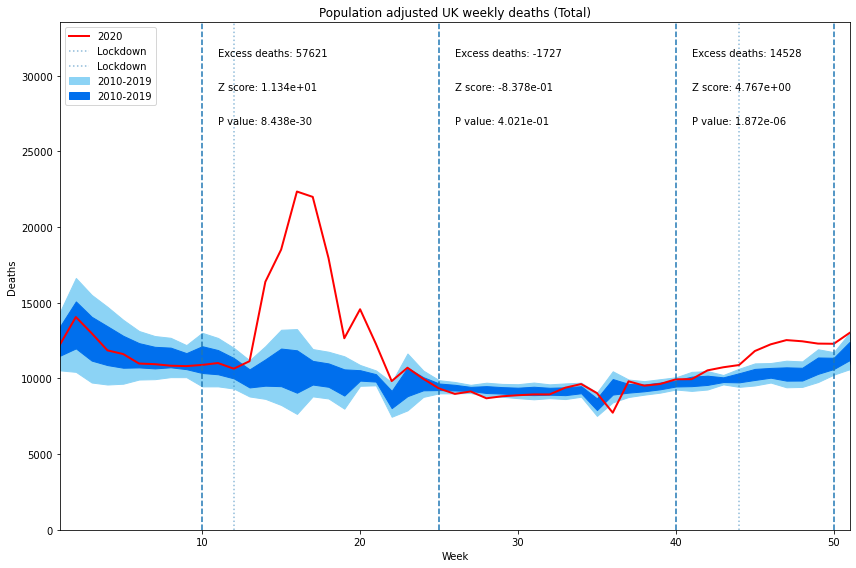

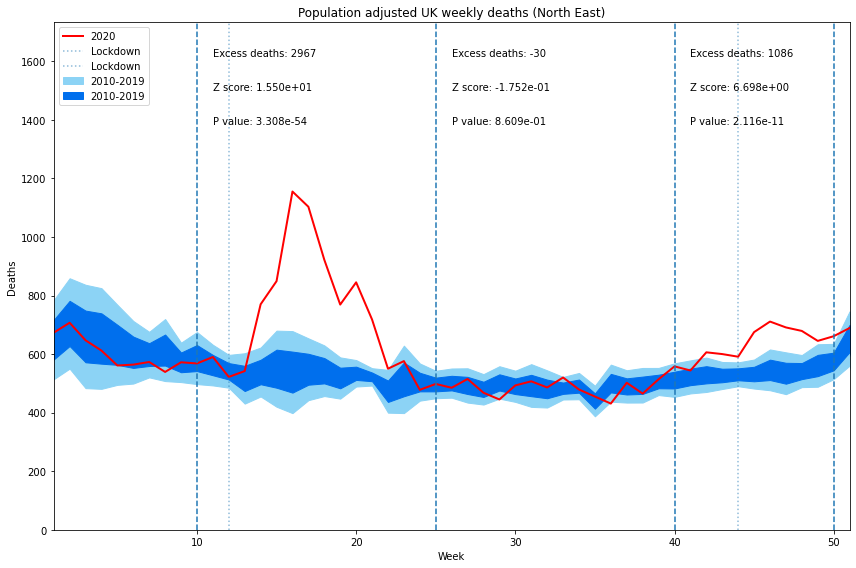

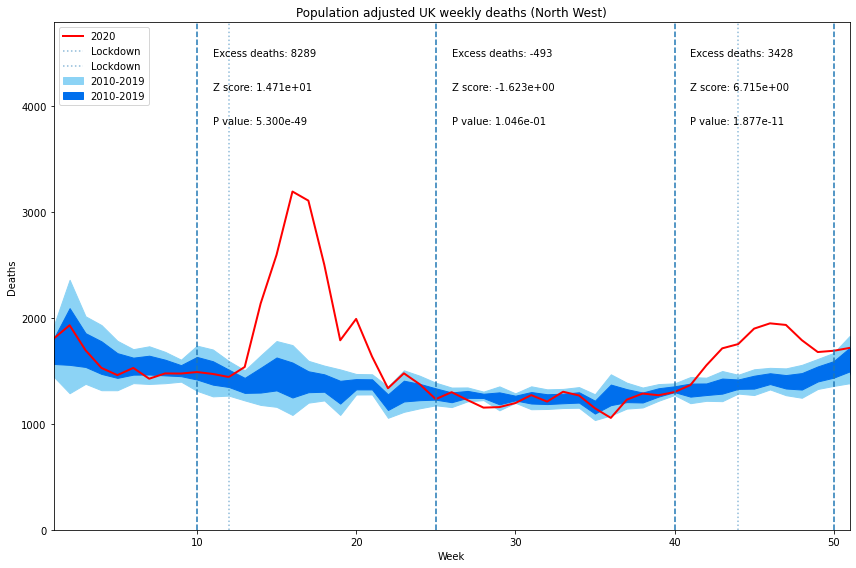

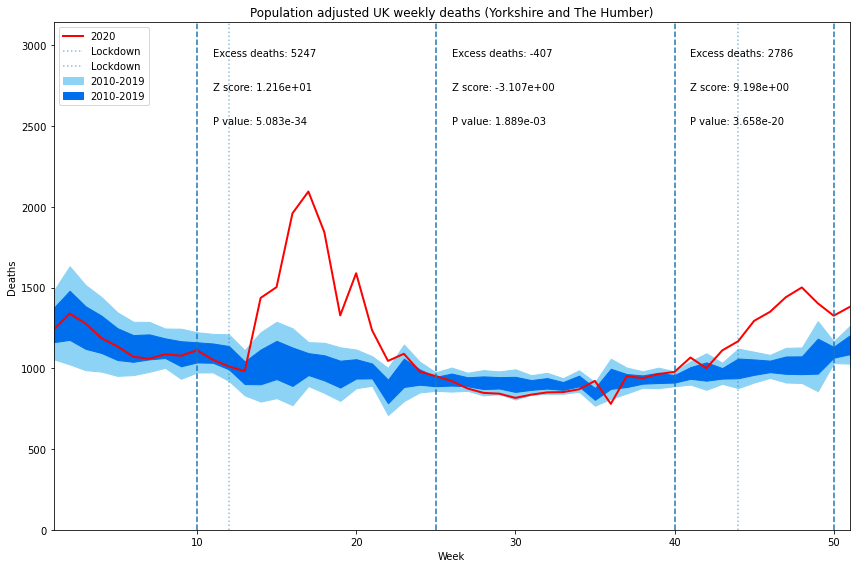

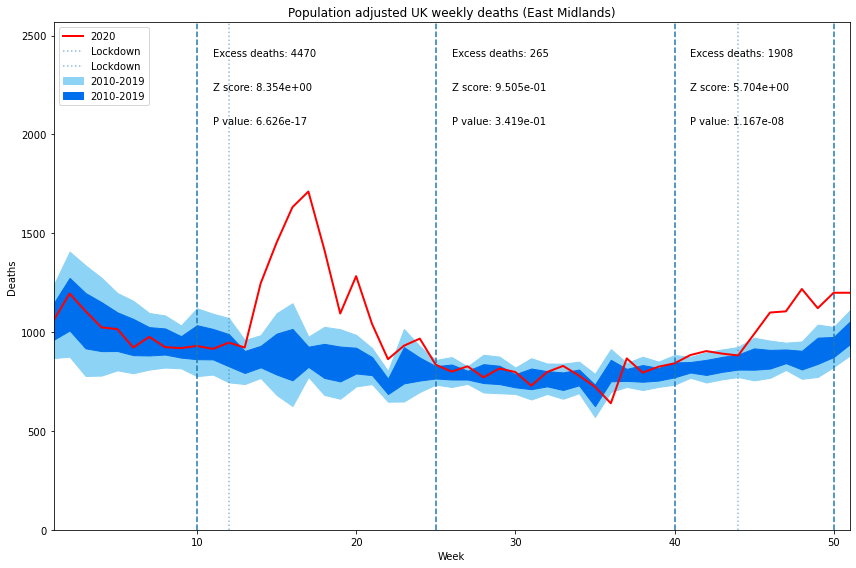

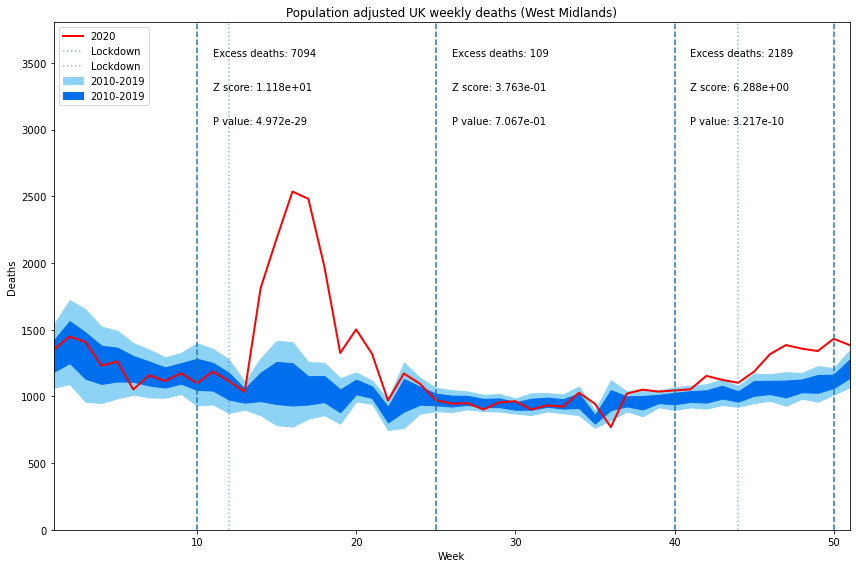

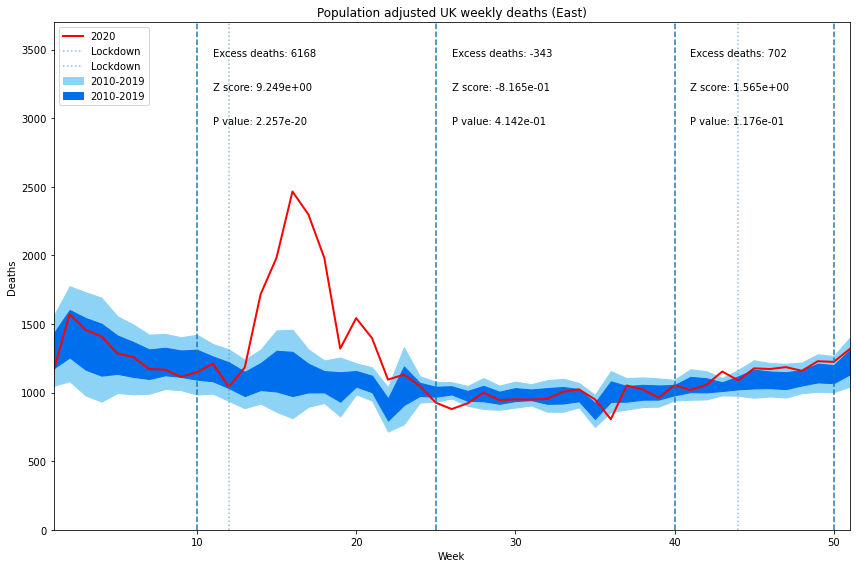

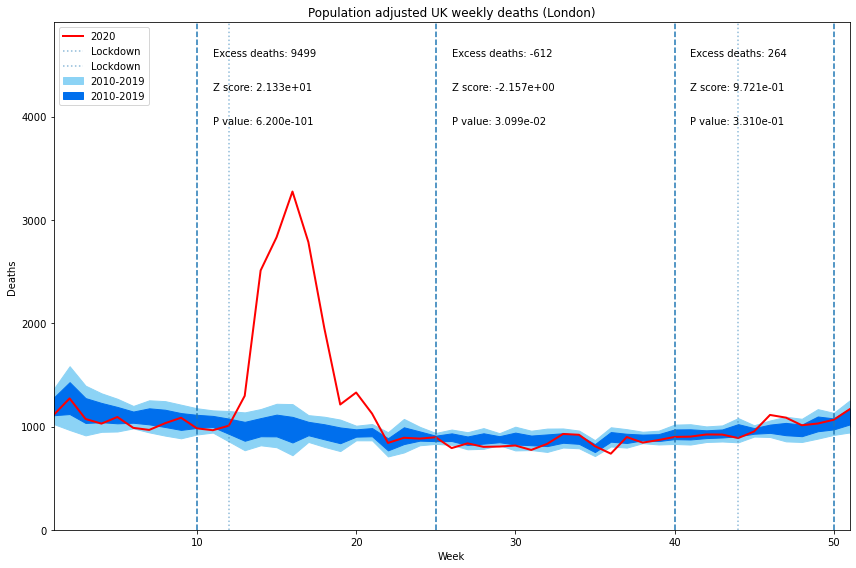

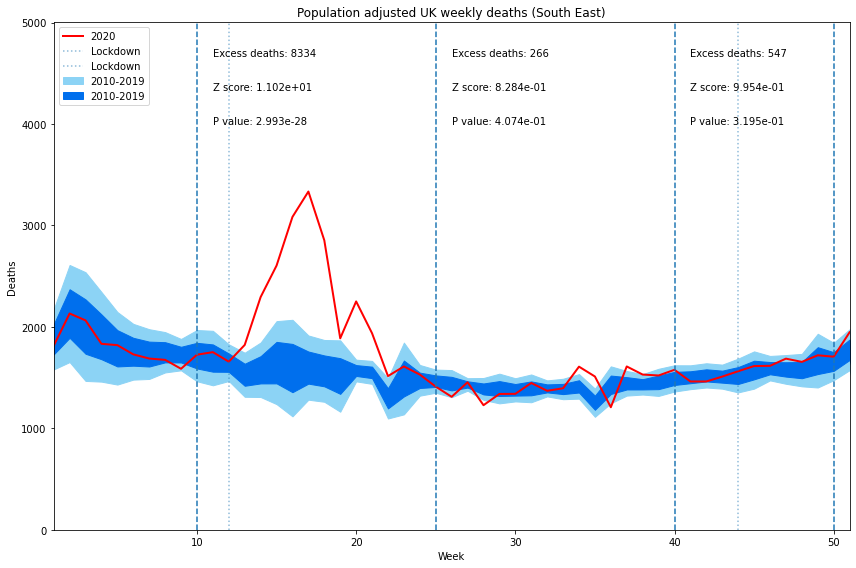

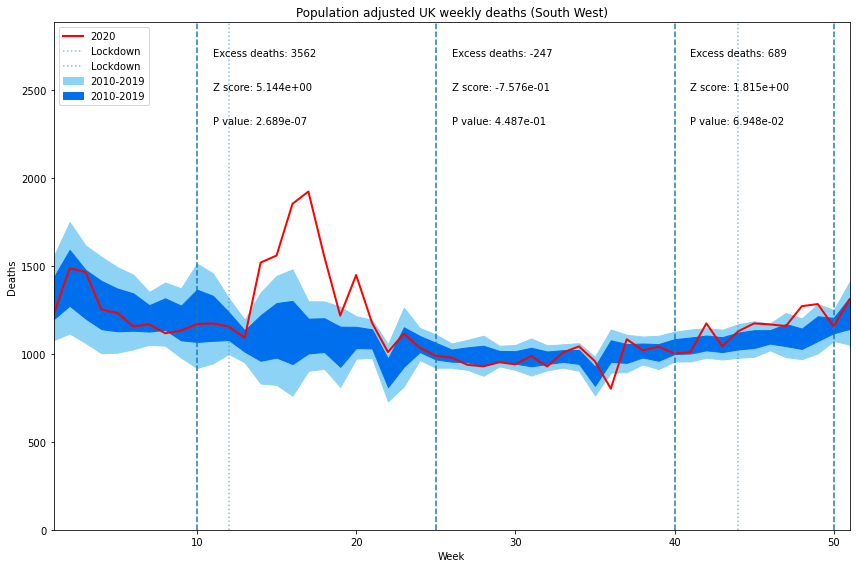

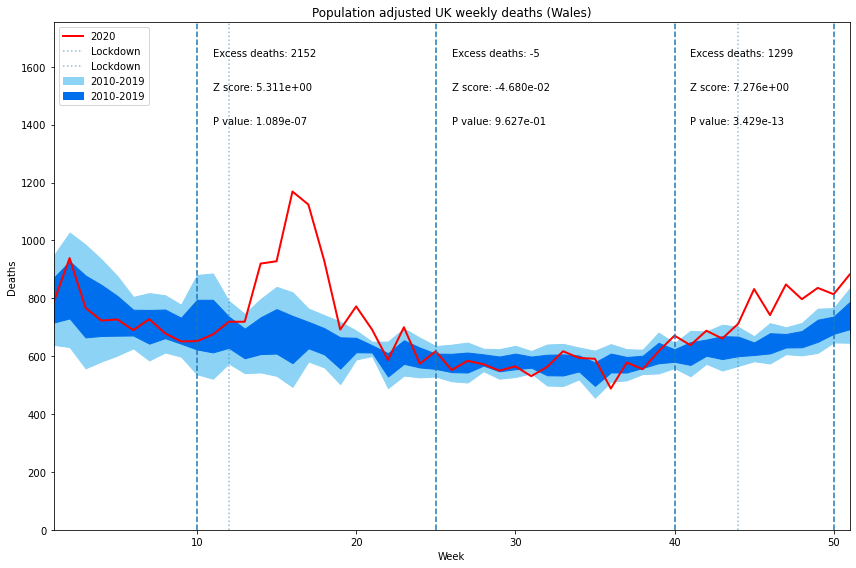

In [14]:
for region in df['areaName'].unique():
    df_region = df[(df['year'] <= 2019) & (df['areaName'] == region)]
    agg = df_region.groupby(['week']).agg({'totalDeathsCorrected': [np.mean, np.std]}).reset_index()
    plt.figure(figsize=(12,8))
    plt.fill_between(agg['week'], agg['totalDeathsCorrected']['mean'] - 2*agg['totalDeathsCorrected']['std'], 
                     agg['totalDeathsCorrected']['mean'] + 2*agg['totalDeathsCorrected']['std'], color='#8CD3F5', label='2010-2019')
    plt.fill_between(agg['week'], agg['totalDeathsCorrected']['mean'] - agg['totalDeathsCorrected']['std'], 
                     agg['totalDeathsCorrected']['mean'] + agg['totalDeathsCorrected']['std'], color='#006FED', label='2010-2019')
    df_region = df[(df['year'] == 2020) & (df['areaName'] == region)]
    plt.plot(df_region['week'], df_region['totalDeaths'], color='red', linewidth=2, label='2020')
    max_deaths = np.max(df_region['totalDeaths'])
    plt.xlabel('Week')
    plt.ylabel('Deaths')
    plt.title('Population adjusted UK weekly deaths (' + region + ')')
    plt.axvline(12, linestyle=':', alpha=0.5, label='Lockdown')
    plt.axvline(44, linestyle=':', alpha=0.5, label='Lockdown')
    excess_deaths, z_score, p_value = get_excess_deaths(10, 25, region)
    plt.text(11, max_deaths * 1.4, 'Excess deaths: %s' % excess_deaths, rotation=0)
    plt.text(11, max_deaths * 1.3, 'Z score: %.3e' % z_score, rotation=0)
    plt.text(11, max_deaths * 1.2, 'P value: %.3e' % p_value, rotation=0)
    excess_deaths, z_score, p_value = get_excess_deaths(25, 40, region)
    plt.text(26, max_deaths * 1.4, 'Excess deaths: %s' % excess_deaths, rotation=0)
    plt.text(26, max_deaths * 1.3, 'Z score: %.3e' % z_score, rotation=0)
    plt.text(26, max_deaths * 1.2, 'P value: %.3e' % p_value, rotation=0)
    excess_deaths, z_score, p_value = get_excess_deaths(40, 51, region)
    plt.text(41, max_deaths * 1.4, 'Excess deaths: %s' % excess_deaths, rotation=0)
    plt.text(41, max_deaths * 1.3, 'Z score: %.3e' % z_score, rotation=0)
    plt.text(41, max_deaths * 1.2, 'P value: %.3e' % p_value, rotation=0)
    plt.axvline(10, linestyle='--')
    plt.axvline(25, linestyle='--')
    plt.axvline(40, linestyle='--')
    plt.axvline(50, linestyle='--')
    plt.xlim([1,51])
    plt.ylim([0, max_deaths * 1.5])
    plt.legend()
    plt.tight_layout()
    plt.savefig('plots/total_deaths_' + region + '.png', transparent=False, facecolor='white')
                